In [1]:
from tensorflow.keras.models import load_model
from skimage import filters
import matplotlib.pyplot as plt 
from random import randint
from skimage import transform
import tensorflow as tf
import pandas as pd
import nibabel as nib
import scipy
import os 
import numpy as np
import random
import utils_reg as ut
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from skimage.transform import resize
import rec
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

def rescale(data, max=255):
    '''
    rescale array to [0 max]
    '''
    
    data = data-np.min(np.ravel(data))
    data = max* (data/np.max(np.ravel(data)))
    return data

/Users/elena/miniconda3/envs/aicuram/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Visualise training history

In [47]:
fold1 = pd.read_csv("training_hist/1training.csv")
fold2 = pd.read_csv("training_hist/2training.csv")
fold3 = pd.read_csv("training_hist/3training.csv")
fold4 = pd.read_csv("training_hist/4training.csv")
fold5 = pd.read_csv("training_hist/5training.csv")
df_loss = pd.concat([fold1.loss, fold2.loss, fold3.loss, fold4.loss, fold5.loss], axis=1)
df_loss = df_loss.mean(axis=1)
df_val_loss = pd.concat([fold1.val_loss, fold2.val_loss, fold3.val_loss, fold4.val_loss, fold5.val_loss], axis=1)
df_val_loss = df_val_loss.mean(axis=1)

In [79]:
print(fold1[fold1['val_loss']<0.03])
print(fold2[fold2['val_loss']<0.03])
print(fold3[fold3['val_loss']<0.03])
print(fold4[fold4['val_loss']<0.03])
print(fold5[fold5['val_loss']<0.03])

      epoch      loss  mean_absolute_error  val_loss  val_mean_absolute_error
249     249  0.030346             0.024969  0.029744                 0.027565
393     393  0.020654             0.025426  0.029797                 0.019692
462     462  0.016331             0.019392  0.029940                 0.024725
748     748  0.013155             0.014156  0.022522                 0.021998
785     785  0.013465             0.015389  0.028454                 0.022579
856     856  0.015115             0.018867  0.020241                 0.023701
873     873  0.014261             0.016879  0.022586                 0.021341
958     958  0.012735             0.015854  0.028790                 0.024438
1432   1432  0.009595             0.011958  0.028291                 0.021758
1554   1554  0.009333             0.011067  0.019214                 0.028788
      epoch      loss  mean_absolute_error  val_loss  val_mean_absolute_error
1237   1237  0.011302             0.016165  0.028759            

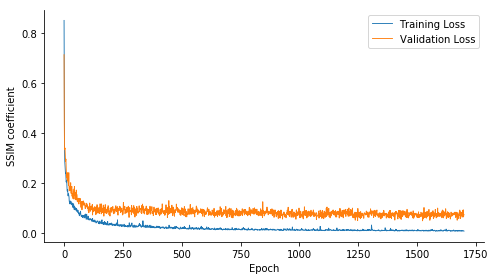

In [74]:
df_final = pd.concat([df_loss, df_val_loss], axis=1)
df_final.plot(figsize=(7,4), lw=0.9)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('SSIM coefficient')
sns.despine(left=False, bottom=False, top=True, right=True)

plt.tight_layout()
plt.savefig('rec_training_avg.pdf')

plt.show()

## Examples

Load the data

In [67]:
data_path = '/Users/elena/aicura/segmentation/wmh/REC/data/'
with open(data_path+'5x_test.pkl', 'rb') as f:
    x = pickle.load(f)

with open(data_path+'5gt_test.pkl', 'rb') as f:
    gt = pickle.load(f)
x = np.squeeze(x, axis=1)
gt = np.squeeze(gt, axis=1)
gt = gt[:,:,:,:,1]
flair = x[:,:,:,:,1]
flair = rescale(flair, max=1)
flair[gt>0] = 0
flair = np.expand_dims(flair, axis = 4)
gt = np.expand_dims(gt, axis = 4)


In [91]:
with open(data_path+'1x_test.pkl', 'rb') as f:
    x = pickle.load(f)
x = np.squeeze(x, axis=1)
flair_gt = x[:,:,:,:,1]
flair_gt = rescale(flair_gt, max=1)
flair_gt = np.expand_dims(flair_gt, axis = 4)


In [92]:
with open('1pred.pkl', 'rb') as f:
    pred = pickle.load(f)
pred.shape

(21, 128, 128, 128, 1)

In [109]:
pred1 = rescale(pred, max=1)

In [118]:
em = flair_gt - pred

### Visualise examples

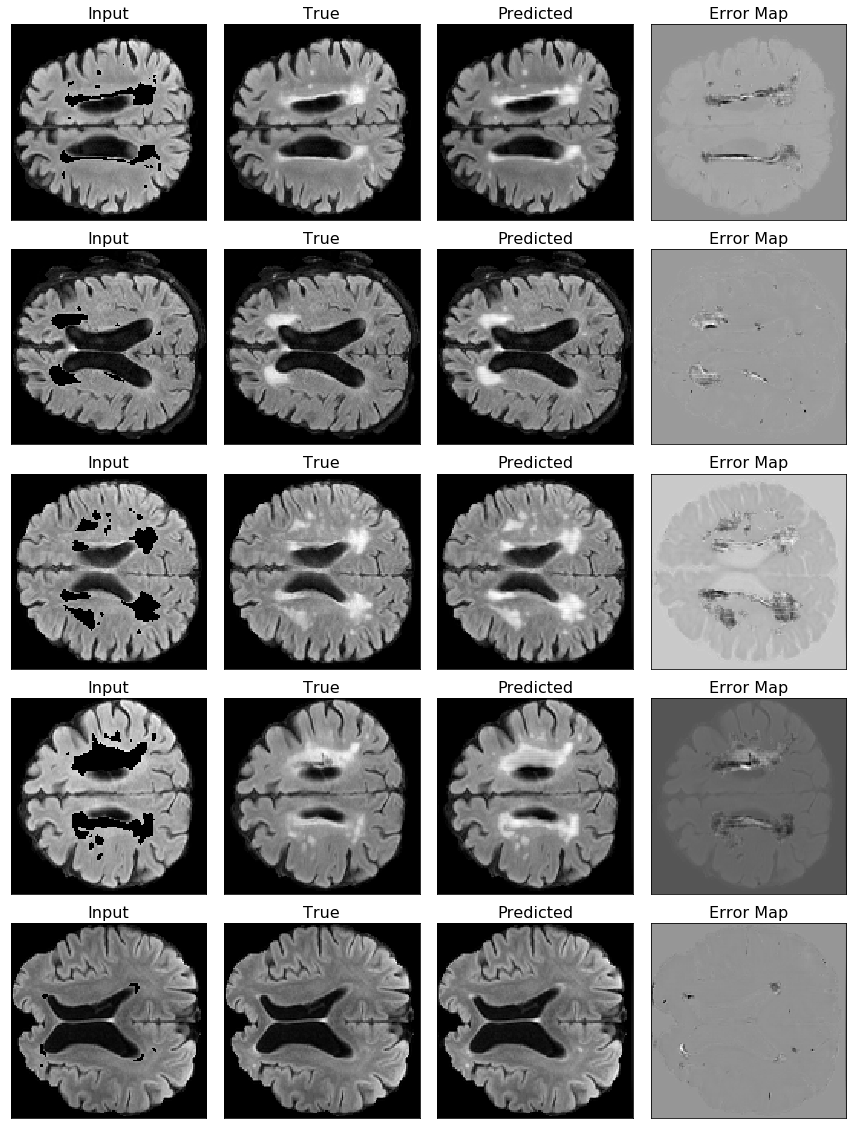

In [73]:
fig, axes = plt.subplots(5,4,figsize=(3*4,4*4))
for i in range(0,5):

    axes[i,0].imshow(flair[i+8,:,:,80,0], cmap='gray')
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].set_title('Input',{'fontsize':16})
    #axes[i,0].set_ylabel(well_ts[i],{'fontsize':16})
    
    axes[i,1].imshow(flair_gt[i+8,:,:,80,0], cmap='gray')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    axes[i,1].set_title('True',{'fontsize':16})
    
    axes[i,2].imshow(pred[i+8,:,:,80,0], cmap='gray')
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])
    axes[i,2].set_title('Predicted',{'fontsize':16})
    
    axes[i,3].imshow(em[i+8,:,:,80, 0], cmap='gray')
    axes[i,3].set_xticks([])
    axes[i,3].set_yticks([])
    axes[i,3].set_title('Error Map',{'fontsize':16})
    plt.tight_layout()

plt.tight_layout()

plt.savefig('em_examples.pdf',bbox_inces='tight',dpi=100)

### VS

Estimate the voxel-wise sum measure

In [94]:
data_path = '/Users/elena/aicura/segmentation/wmh/REC/data/'

dice_values = np.loadtxt(data_path+'1dice_test.txt', dtype=float)


In [119]:
e_map = rescale(em, max=1)


In [120]:
em_sum = []
for i in np.arange(0,21):
    value = (np.sum(e_map[i,:,:,:,0]))
    em_sum.append(value)

em_sum = np.array(em_sum)
print(em_sum.shape)

(21,)


In [115]:
em_sum

array([1376467.45425477, 1304586.6722521 , 1377009.64233996,
       1384266.67941716, 1391928.55874352, 1335253.92836523,
       1303929.77018821, 1352012.43097304, 1399256.22837048,
       1311931.72009241, 1344365.75996847, 1379456.66866862,
       1311779.29168577, 1337521.52704235, 1322846.57243788,
       1322366.3456035 , 1326612.92661837, 1312622.06192957,
       1317756.35533665, 1299754.73596653, 1276062.97037272])

Estimate correlation between dice and VS

In [106]:
import scipy.stats
statss = scipy.stats.pearsonr(dice_values, em_sum)

In [117]:
statss

(0.3333540518858676, 0.13975583960250584)

### Scatterplot

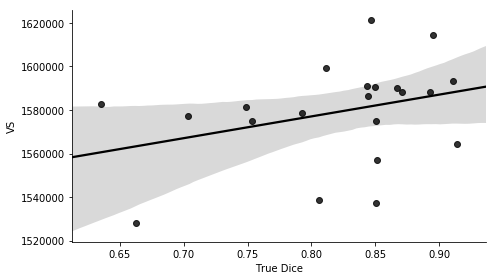

In [121]:
plt.figure(figsize=(7,4))
sns.regplot(dice_values, em_sum, 'o', color='black')
plt.xlabel('True Dice')
plt.ylabel('VS')
sns.despine(left=False, bottom=False, top=True, right=True)
plt.tight_layout()
plt.savefig('VSscatter.pdf')